In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import re
import hashlib
import numpy as np
import spacy

from tqdm import tqdm

from spacy.matcher import Matcher
from sklearn.metrics import accuracy_score, f1_score 
from nltk.tokenize import WordPunctTokenizer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import EnglishStemmer
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from spellchecker import SpellChecker



In [2]:
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("merge_entities", after="ner")
en_stopwords = nlp.Defaults.stop_words

In [3]:
cpu_count = min(int(os.cpu_count()), 4) if os.cpu_count() != None else 4

In [4]:
def convert_series2docs(nlp_, data_: pd.Series, num_processes: int):
    docs_ = list(tqdm(nlp_.pipe(data_, batch_size=20, n_process=num_processes), total=len(data_)))
    return docs_

In [5]:
df_dataset = pd.read_csv("data/dataset.csv")

In [6]:
df_dataset

,text,date,category,language
0,"Hello, Does it matter iff I use Visa or Master...",7-6-2022,visa_or_mastercard,en
1,"Good afternoon, I just got refunded for my pur...",16-11-2022,reverted_card_payment?,en
2,"Hello, I got billed ann extra pound! Thanks",4-12-2022,extra_charge_on_statement,en
3,"Hi, How long does it take for a transfer to sh...",23-11-2022,transfer_timing,en
4,"hi, When can I use money sent to my accountt? ...",17-4-2022,transfer_timing,en
...,...,...,...,...
9370,"good afternoon, I think someone may be using m...",22-6-2022,compromised_card,en
9371,"good morning, Help, I need to top up my accoun...",7-4-2022,top_up_by_cash_or_cheque,en
9372,"hi, I made an international purchasee, but the...",7-12-2022,card_payment_wrong_exchange_rate,en
9373,"hi, Why is my card not working anymore? Thanks",1-11-2022,card_not_working,en


In [7]:
df_mapping = pd.read_csv("data/mapping.csv")

In [8]:
df_mapping

,category,class
0,card_arrival,card
1,card_linking,card
2,exchange_rate,others
3,card_payment_wrong_exchange_rate,card
4,extra_charge_on_statement,others
...,...,...
72,cash_withdrawal_charge,cash
73,card_about_to_expire,card
74,apple_pay_or_google_pay,others
75,verify_my_identity,others


In [9]:
df_merged = pd.merge(left=df_dataset, right=df_mapping, on='category', how='left', suffixes=(None, 'map'))

In [10]:
df_merged

,text,date,category,language,class
0,"Hello, Does it matter iff I use Visa or Master...",7-6-2022,visa_or_mastercard,en,card
1,"Good afternoon, I just got refunded for my pur...",16-11-2022,reverted_card_payment?,en,card
2,"Hello, I got billed ann extra pound! Thanks",4-12-2022,extra_charge_on_statement,en,others
3,"Hi, How long does it take for a transfer to sh...",23-11-2022,transfer_timing,en,transfer
4,"hi, When can I use money sent to my accountt? ...",17-4-2022,transfer_timing,en,transfer
...,...,...,...,...,...
9370,"good afternoon, I think someone may be using m...",22-6-2022,compromised_card,en,card
9371,"good morning, Help, I need to top up my accoun...",7-4-2022,top_up_by_cash_or_cheque,en,cash
9372,"hi, I made an international purchasee, but the...",7-12-2022,card_payment_wrong_exchange_rate,en,card
9373,"hi, Why is my card not working anymore? Thanks",1-11-2022,card_not_working,en,card


<AxesSubplot:>

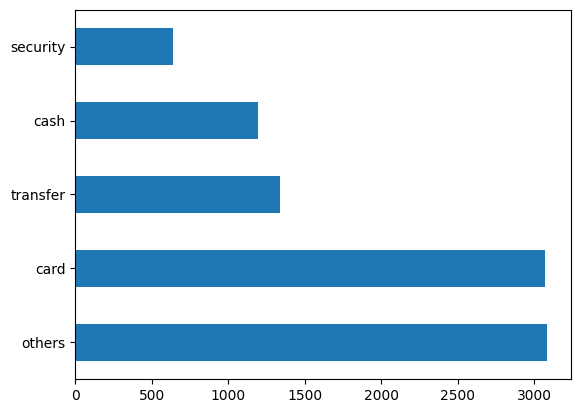

In [11]:
df_merged["class"].value_counts().plot.barh()

<AxesSubplot:>

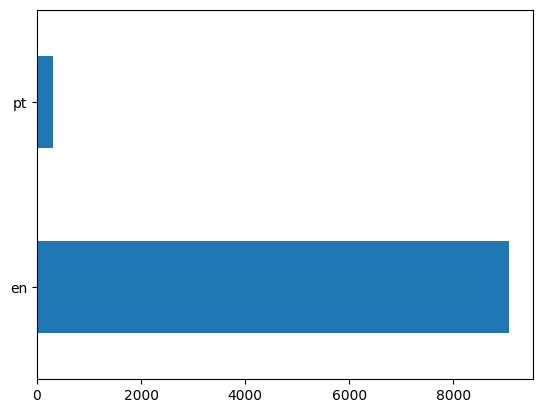

In [12]:
df_merged["language"].value_counts().plot.barh()

In [13]:
df_merged.loc[df_merged["language"] == "pt"]

,text,date,category,language,class
28,"Olá, Posso obter uma atualização sobre o meu c...",11-7-2022,extra_charge_on_statement,pt,others
29,"Boas, Encontrei o meu cartão no meu casaco est...",26-12-2022,cash_withdrawal_not_recognised,pt,cash
38,"Olá, Quero reativar o meu cartão. Pensei que o...",7-4-2022,unable_to_verify_identity,pt,others
39,"Olá, E se eu quiser adicionar um cartão que já...",2-8-2022,direct_debit_payment_not_recognised,pt,others
49,"Olá, Posso voltar a colocar o meu cartão antig...",22-7-2022,change_pin,pt,security
...,...,...,...,...,...
9273,"Olá, Encontrei o cartão que pensei ter perdido...",29-8-2022,receiving_money,pt,others
9279,"Boas, Quero reativar o meu cartão. Pensei que ...",12-1-2022,get_disposable_virtual_card,pt,card
9290,"Boa noite, Como faço para vincular um novo car...",20-11-2022,card_arrival,pt,card
9306,"Boa noite, Por que não recebi o meu novo cartã...",5-8-2022,atm_support,pt,others


In [14]:
df_clean = df_merged.loc[df_merged["language"] == "en"].copy()

In [15]:
df_clean = df_clean.drop(columns=["date", "category", "language"])

In [16]:
df_clean

,text,class
0,"Hello, Does it matter iff I use Visa or Master...",card
1,"Good afternoon, I just got refunded for my pur...",card
2,"Hello, I got billed ann extra pound! Thanks",others
3,"Hi, How long does it take for a transfer to sh...",transfer
4,"hi, When can I use money sent to my accountt? ...",transfer
...,...,...
9370,"good afternoon, I think someone may be using m...",card
9371,"good morning, Help, I need to top up my accoun...",cash
9372,"hi, I made an international purchasee, but the...",card
9373,"hi, Why is my card not working anymore? Thanks",card


In [17]:
df_clean.isna().sum()

text      0
class    35
dtype: int64

In [18]:
df_clean[df_clean["class"].isna()]

,text,class
24,We have hope. Rebellions are built on hope.,NaN
1155,"I'm one with the Force, and the Force will gui...",NaN
1305,Lesson one from this experience: Realize how m...,NaN
1459,The belonging you seek is not behind you; it i...,NaN
2023,I am one with the Force. The Force is with me.,NaN
2107,Try not. Do or do not. There is no try.,NaN
2176,That's not how the Force works!,NaN
2222,No one’s ever really gone.,NaN
2412,Never tell me the odds!,NaN
2453,I'll never turn to the dark side.,NaN


In [19]:
df_clean = df_clean.loc[df_clean["class"].notna()]

In [20]:
df_clean.isna().sum()

text     0
class    0
dtype: int64

In [21]:
df_aux = df_clean.copy()

In [22]:
df_aux["text"].str.split(',', expand=True, n=1)[1]

0        Does it matter iff I use Visa or Mastercard? ...
1        I just got refunded for my purchase over two ...
2                    I got billed ann extra pound! Thanks
3        How long does it take for a transfer to show ...
4        When can I use money sent to my accountt? bes...
                              ...                        
9370     I think someone may be using my card. Kind Re...
9371     Help, I need to top up my account. Where do I...
9372     I made an international purchasee, but the ex...
9373           Why is my card not working anymore? Thanks
9374     How many different cards can I havee for my a...
Name: 1, Length: 9038, dtype: object

In [23]:
def remove_punctuation(text):


    text = re.sub(r'[^\w\s]+', '', text)

    return text.lower()

In [24]:
nlp = spacy.load('en_core_web_sm')
en_stopwords = nlp.Defaults.stop_words
tokenizer = WordPunctTokenizer()


In [25]:
def remove_stopwords(text, stopwords):
    token_text = tokenizer.tokenize(text)
    text_no_sw = [word for word in token_text if word not in en_stopwords]
    text_processed = ' '.join(text_no_sw)
    # Return the full string again here
    return text_processed

In [26]:
spell = SpellChecker()


In [27]:
spell.unknown(['something', 'is', 'hapenning', 'here'])

{'hapenning'}

In [28]:
spell.correction('accountt')

'account'

In [29]:
spell = SpellChecker()
def correct_spelling (sentence_: str, spell_checker: SpellChecker):
    

    # find those words that may be misspelled
    sentence_corrected = []
    misspelled = spell_checker.unknown(sentence_.split())
    
    for word_ in sentence_.split():
        if word_ in misspelled:
            word_corrected = spell_checker.correction(word_)
            if word_corrected==None:
                word_corrected = word_
        else:
            word_corrected = word_

        sentence_corrected.append(word_corrected)

    sentence_corrected = " ".join(sentence_corrected)
    return sentence_corrected

In [30]:
def preprocess_text(df):

    df_processed = df.copy()
    try: 
        df_processed["text"] = df_processed["text"].str.split(',', expand=True, n=1)[1]
        df_processed["text"] = df_processed["text"].apply(lambda x: remove_punctuation(x))
    except:
        df_processed = df.copy()
        df_processed["text"] = df_processed["text"].apply(lambda x: remove_punctuation(x))

    spell = SpellChecker()
    
    df_processed["text"] = df_processed['text'].apply(lambda x: correct_spelling (x, spell))

    df_processed["text"] = df_processed["text"].apply(remove_stopwords, stopwords = en_stopwords)


    df_processed["nb_words"] = df_processed['text'].str.split().map(len)
    df_processed["doc_length"] = df_processed['text'].map(len)
    df_processed["avg_word_length"] =  df_processed['text'].apply(lambda x: np.mean([len(t) for t in x.split(' ')]) if len([len(t) for t in x.split(' ')]) > 0 else 0)

    return df_processed

df_aux = preprocess_text(df_aux)

In [31]:
df_aux["text"]

0                   matter iff use visa mastercard thanks
1            got refunded purchase weeks ago best regards
2                       got billed ann extra pound thanks
3                            long transfer account thanks
4                     use money sent account best regards
                              ...                        
9370                              think card kind regards
9371            help need account send check best regards
9372    international purchase exchange rate wrong thanks
9373                          card working anymore thanks
9374                 different cards account kind regards
Name: text, Length: 9038, dtype: object

In [32]:
df_aux["text"].drop_duplicates()

0                   matter iff use visa mastercard thanks
1            got refunded purchase weeks ago best regards
2                       got billed ann extra pound thanks
3                            long transfer account thanks
4                     use money sent account best regards
                              ...                        
9370                              think card kind regards
9371            help need account send check best regards
9372    international purchase exchange rate wrong thanks
9373                          card working anymore thanks
9374                 different cards account kind regards
Name: text, Length: 8546, dtype: object

In [33]:
stemmer = EnglishStemmer()
analyzer = TfidfVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

In [34]:
class Selector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a column from the dataframe to perform additional transformations on
    """ 
    def __init__(self, key):
        self.key = key
        
    def fit(self, X, y=None):
        return self
    

class TextSelector(Selector):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def transform(self, X):
        return X[self.key]
    
    
class NumberSelector(Selector):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def transform(self, X):
        return X[[self.key]]
    

In [35]:
text_pipe = Pipeline([
                ('selector', TextSelector("text")),
                ('tfidf', TfidfVectorizer(ngram_range=(1,2), analyzer=stemmed_words))
            ])
nb_words_pipe =  Pipeline([
                ('selector', NumberSelector(key='nb_words')),
                ('standard', StandardScaler())
            ])
doc_length_pipe =  Pipeline([
                ('selector', NumberSelector(key='doc_length')),
                ('standard', StandardScaler())
            ])
avg_word_length_pipe =  Pipeline([
                ('selector', NumberSelector(key='avg_word_length')),
                ('standard', StandardScaler()),
            ])


feats = FeatureUnion([('text', text_pipe), 
                      ('nb_words', nb_words_pipe),
                      ('doc_length', doc_length_pipe),
                      ('avg_word_length', avg_word_length_pipe)])

In [36]:
def improved_pipeline(feats, X_train, X_test, y_train, y_test):
    """
    Train a Random Forest using sklearn's Pipeline and return the trained model and its accuracy in the test set.
    Don't forget to add the feats to the Pipeline!
    """
    
    # pipe = (...)
    # pipe.fit(...)
    # (...)
    
    # YOUR CODE HERE
    
    pipe = Pipeline([
        ('feats',feats),
        ('classifier', GradientBoostingClassifier()),])
    
    pipe.fit(X_train, y_train)

    preds = pipe.predict(X_test)
    acc = accuracy_score(y_true=y_test, y_pred=preds)
    
    #raise NotImplementedError()
    
    return pipe, acc

In [37]:
Y = df_aux["class"]
X = df_aux.drop(columns="class")

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
pipeline_model, pipeline_acc = improved_pipeline(feats, X_train, X_test, y_train, y_test)

In [38]:
pipe = Pipeline([
        ('feats',feats),
        ('classifier', RandomForestClassifier()),])
    
pipe.fit(X_train, y_train)

preds = pipe.predict(X_test)
acc = accuracy_score(y_true=y_test, y_pred=preds)
f1 = f1_score(y_true=y_test, y_pred=preds, average=None)



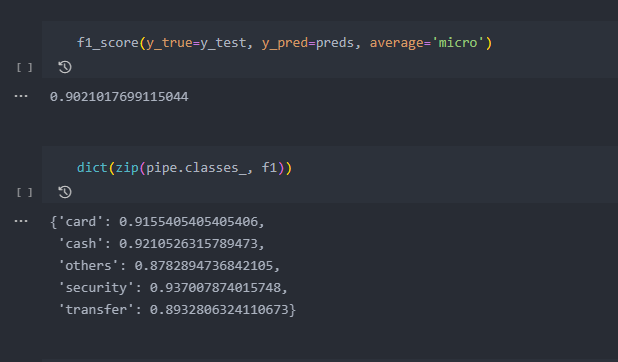

In [39]:
f1_score(y_true=y_test, y_pred=preds, average='micro')

0.9209070796460177

In [40]:
dict(zip(pipe.classes_, f1))

{'card': 0.9327659574468085,
 'cash': 0.9318681318681318,
 'others': 0.9011532125205931,
 'security': 0.9444444444444443,
 'transfer': 0.9192307692307692}

In [41]:
print(f1)

[0.93276596 0.93186813 0.90115321 0.94444444 0.91923077]


In [42]:
X_test["class"] = preds

/tmp/ipykernel_3002/3848072420.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["class"] = preds


In [43]:
X_test

,text,nb_words,doc_length,avg_word_length,class
7417,ii card saying pending mean thanks,6,34,4.833333,card
1040,like account bank transfer allowed kind regards,7,47,5.857143,transfer
6668,foreign currency exchange applied incorrectly ...,6,52,7.833333,others
8315,whats card sent mes tracking number best regards,8,48,5.125000,card
5005,card active best regards,4,24,5.250000,card
...,...,...,...,...,...
7684,basis exchange rates kind regards,5,33,5.800000,others
681,sent payment isn ' t showing app thanks,8,39,4.000000,card
5076,doo find exchange rate best regards,6,35,5.000000,others
1977,doo find exchange fees best regards,6,35,5.000000,others


In [44]:
test_data = pd.read_csv("data/test_dataset.csv")
test_data.head()

,text
0,How do I locate my card?
1,Why won't my card show up on the app?
2,I need to know your exchange rates.
3,I purchased something in a foreign currency bu...
4,My statement has a dollar I have been charged ...


In [45]:
test_aux = preprocess_text(test_data)
test_aux.head()

,text,nb_words,doc_length,avg_word_length
0,locate card,2,11,5.000000
1,wont card app,3,13,3.666667
2,need know exchange rates,4,24,5.250000
3,purchased foreign currency rate applied wrong,6,45,6.666667
4,statement dollar charged showing,4,32,7.250000


In [46]:
perd_test = pipe.predict(test_aux)
print(perd_test)
len(perd_test)

['card' 'card' 'others' ... 'others' 'others' 'others']


1042

In [47]:
test_class = pd.DataFrame({'class': perd_test})

In [48]:
test_class

,class
0,card
1,card
2,others
3,card
4,others
...,...
1037,card
1038,others
1039,others
1040,others


In [49]:
test_class.to_csv("data/sub_test_gradboost_stemmer_nogm_spellchecked.csv", index=False)